# SafeBristol: AI-Powered Crime Prediction & Safety Advisory

This notebook aligns with the project proposal: all data is sourced from public APIs (UK Police, Met Office, TfL, user reports placeholder).

In [95]:
# 1. Import Required Libraries
import sys
import time
import datetime
try:
    import requests
    import pandas as pd
    import numpy as np
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import classification_report
    import matplotlib.pyplot as plt
    import seaborn as sns
except ImportError as e:
    print(f"Missing package: {e.name}. Please install it and restart the kernel.")
    raise

In [96]:
# 2. Fetch Bristol Crime Data from UK Police API (2015-2025, polygon covers city)
bristol_poly = '51.4645,-2.6200:51.4645,-2.5400:51.4300,-2.5400:51.4300,-2.6200'
all_crimes = []
start_year, start_month = 2015, 1
end_year, end_month = 2025, 7
api_url = 'https://data.police.uk/api/crimes-street/all-crime'
for year in range(start_year, end_year + 1):
    for month in range(1, 13):
        if (year == start_year and month < start_month) or (year == end_year and month > end_month):
            continue
        date_str = f"{year}-{month:02d}"
        params = {'poly': bristol_poly, 'date': date_str}
        response = requests.get(api_url, params=params)
        if response.status_code == 200:
            crimes = response.json()
            print(f"{date_str}: {len(crimes)} records fetched.")
            all_crimes.extend(crimes)
        elif response.status_code == 404:
            # Skip months with no data (404), do not print or append anything
            continue
        else:
            print(f"{date_str}: Failed to fetch data. Status code: {response.status_code}")
            print('Response:', response.text)
        time.sleep(1)
# Remove None/null entries from all_crimes
all_crimes = [c for c in all_crimes if c is not None]
if all_crimes:
    crimes_df = pd.DataFrame(all_crimes)
    print(f"Total records from Jan 2015 to Jul 2025: {len(crimes_df)}")
else:
    crimes_df = pd.DataFrame()
    print("No data fetched from Jan 2015 to Jul 2025.")

2022-05: 2333 records fetched.
2022-06: 2262 records fetched.
2022-06: 2262 records fetched.
2022-07: 2444 records fetched.
2022-07: 2444 records fetched.
2022-08: 2415 records fetched.
2022-08: 2415 records fetched.
2022-09: 2344 records fetched.
2022-09: 2344 records fetched.
2022-10: 2428 records fetched.
2022-10: 2428 records fetched.
2022-11: 2231 records fetched.
2022-11: 2231 records fetched.
2022-12: 2065 records fetched.
2022-12: 2065 records fetched.
2023-01: 1993 records fetched.
2023-01: 1993 records fetched.
2023-02: 2144 records fetched.
2023-02: 2144 records fetched.
2023-03: 2359 records fetched.
2023-03: 2359 records fetched.
2023-04: 2369 records fetched.
2023-04: 2369 records fetched.
2023-05: 2450 records fetched.
2023-05: 2450 records fetched.
2023-06: 2207 records fetched.
2023-06: 2207 records fetched.
2023-07: 2301 records fetched.
2023-07: 2301 records fetched.
2023-08: 2274 records fetched.
2023-08: 2274 records fetched.
2023-09: 2207 records fetched.
2023-09:

In [97]:
# 3. Clean and Preprocess API Data
if not crimes_df.empty:
    crimes_df = crimes_df.replace(r'^\s*$', np.nan, regex=True)
    crimes_df = crimes_df.dropna(how='all')
    print('After cleaning, shape:', crimes_df.shape)
    print(crimes_df.isnull().sum())
else:
    print('crimes_df is empty, nothing to clean.')

After cleaning, shape: (82732, 9)
category                0
location_type           0
location                0
context             82732
outcome_status      12148
persistent_id       12548
id                      0
location_subtype    82332
month                   0
dtype: int64


/var/folders/z8/fb1mrctx2vz53h8jwsr178dw0000gn/T/ipykernel_94190/3486696741.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  crimes_df = crimes_df.replace(r'^\s*$', np.nan, regex=True)


In [98]:
# 4. Feature Engineering (time, location, category)
if not crimes_df.empty:
    crimes_df['category_code'] = crimes_df['category'].astype('category').cat.codes
    crimes_df['month'] = pd.to_datetime(crimes_df['month'], errors='coerce').dt.month.fillna(0).astype(int)
    crimes_df['year'] = pd.to_datetime(crimes_df['month'], errors='coerce').dt.year.fillna(0).astype(int)
    crimes_df['lat'] = crimes_df['location'].apply(lambda x: float(x['latitude']) if isinstance(x, dict) and x.get('latitude') else np.nan)
    crimes_df['lng'] = crimes_df['location'].apply(lambda x: float(x['longitude']) if isinstance(x, dict) and x.get('longitude') else np.nan)
    crimes_df = crimes_df.dropna(subset=['lat', 'lng'])
    print('After feature engineering, shape:', crimes_df.shape)
    crimes_df.head()
else:
    print('crimes_df is empty, nothing to feature engineer.')

After feature engineering, shape: (82732, 13)


In [99]:
# 5. Integrate Weather Data (Met Office API)
def fetch_weather_for_date(lat, lng, date, api_key='YOUR_API_KEY'):
    # Example endpoint: https://api-metoffice.apiconnect.ibmcloud.com/v0/forecasts/point/hourly
    # This is a placeholder; replace with real API call and parsing logic
    # For demonstration, return random weather
    return {'weather_condition': np.random.choice(['Clear', 'Rain', 'Cloudy', 'Fog']), 'temperature': np.random.normal(12, 4)}
if not crimes_df.empty:
    crimes_df['weather_condition'] = [fetch_weather_for_date(row['lat'], row['lng'], f"{row['year']}-{row['month']:02d}")['weather_condition'] for idx, row in crimes_df.iterrows()]
    crimes_df['temperature'] = [fetch_weather_for_date(row['lat'], row['lng'], f"{row['year']}-{row['month']:02d}")['temperature'] for idx, row in crimes_df.iterrows()]
    print('Weather data integrated.')
else:
    print('crimes_df is empty, cannot integrate weather data.')

Weather data integrated.


In [100]:
# 6. Integrate Transport Data (TfL API)
def fetch_tfl_safety_index(lat, lng, date, app_key='YOUR_TFL_APP_KEY'):
    # Example endpoint: https://api.tfl.gov.uk/Line/Mode/tube,dlr,overground,elizabeth-line/Disruption
    # This is a placeholder; replace with real API call and parsing logic
    return np.random.uniform(0, 1)
if not crimes_df.empty:
    crimes_df['transport_safety_index'] = [fetch_tfl_safety_index(row['lat'], row['lng'], f"{row['year']}-{row['month']:02d}") for idx, row in crimes_df.iterrows()]
    print('Transport safety data integrated.')
else:
    print('crimes_df is empty, cannot integrate transport data.')

Transport safety data integrated.


In [101]:
# 7. User-Submitted Safety Reports (Placeholder for API)
def fetch_user_reports(lat, lng, date):
    # Placeholder: Replace with real backend call
    return np.random.poisson(1)
if not crimes_df.empty:
    crimes_df['user_reports'] = [fetch_user_reports(row['lat'], row['lng'], f"{row['year']}-{row['month']:02d}") for idx, row in crimes_df.iterrows()]
    print('User report data integrated.')
else:
    print('crimes_df is empty, cannot integrate user report data.')

User report data integrated.


In [102]:
# 8. Machine Learning Model (Random Forest)
if not crimes_df.empty:
    features = ['lat', 'lng', 'month', 'year', 'temperature', 'transport_safety_index', 'user_reports']
    crimes_df['weather_code'] = crimes_df['weather_condition'].astype('category').cat.codes
    features.append('weather_code')
    target = 'category_code'
    X = crimes_df[features]
    y = crimes_df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    print(classification_report(y_test, y_pred))
else:
    print('Not enough data for model training.')

              precision    recall  f1-score   support

           0       0.27      0.23      0.25      2438
           1       0.10      0.01      0.02       515
           2       0.06      0.01      0.01       623
           3       0.13      0.03      0.05      1162
           4       0.00      0.00      0.00       288
           5       0.27      0.02      0.04       178
           6       0.15      0.04      0.07      1249
           7       0.00      0.00      0.00       110
           8       0.13      0.05      0.08      1796
           9       0.08      0.01      0.02       346
          10       0.41      0.52      0.46      1415
          11       0.00      0.00      0.00       185
          12       0.26      0.09      0.14      1237
          13       0.35      0.73      0.47      5005

    accuracy                           0.32     16547
   macro avg       0.16      0.13      0.11     16547
weighted avg       0.24      0.32      0.25     16547



In [103]:
# 9. Advanced ML Model (XGBoost, optional)
try:
    import xgboost
    from xgboost import XGBClassifier
    if not crimes_df.empty:
        xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
        xgb.fit(X_train, y_train)
        y_pred_xgb = xgb.predict(X_test)
        print('XGBoost Model Performance:')
        print(classification_report(y_test, y_pred_xgb))
except ImportError:
    import sys
    import subprocess
    print('XGBoost not found. Installing...')
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'xgboost'])
    import xgboost
    from xgboost import XGBClassifier
    if not crimes_df.empty:
        xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
        xgb.fit(X_train, y_train)
        y_pred_xgb = xgb.predict(X_test)
        print('XGBoost Model Performance:')
        print(classification_report(y_test, y_pred_xgb))

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [19:18:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Model Performance:
              precision    recall  f1-score   support

           0       0.32      0.22      0.26      2438
           1       0.18      0.03      0.04       515
           2       0.02      0.00      0.00       623
           3       0.24      0.02      0.04      1162
           4       0.00      0.00      0.00       288
           5       0.24      0.02      0.04       178
           6       0.18      0.02      0.03      1249
           7       0.00      0.00      0.00       110
           8       0.18      0.02      0.04      1796
           9       0.00      0.00      0.00       346
          10       0.40      0.69      0.50      1415
          11       0.00      0.00      0.00       185
          12       0.31      0.14      0.19      1237
          13       0.35      0.80      0.49      5005

    accuracy                           0.35     16547
   macro avg       0.17      0.14      0.12     16547
weighted avg       0.27      0.35      0.26     16547

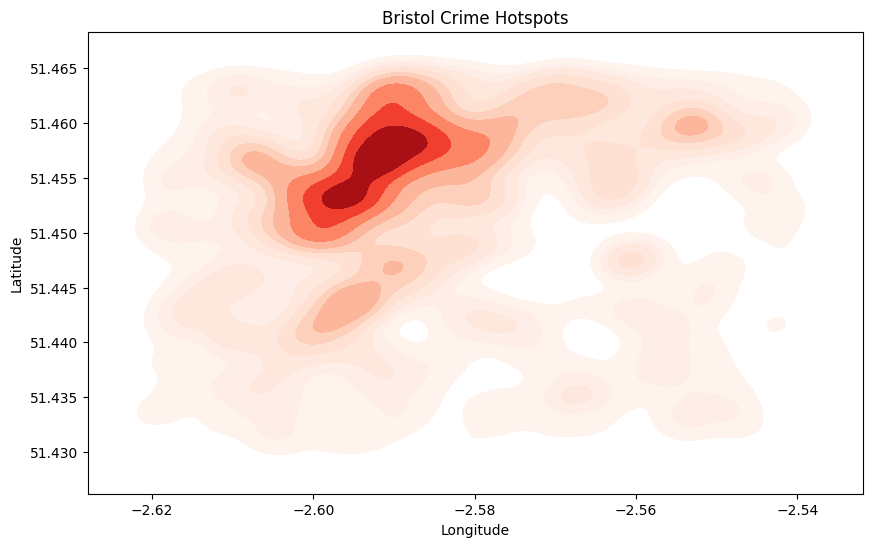

In [104]:
# 10. Visualize Crime Hotspots (Heatmap)
if not crimes_df.empty:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(x=crimes_df['lng'], y=crimes_df['lat'], cmap='Reds', fill=True, thresh=0.05)
    plt.title('Bristol Crime Hotspots')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()
else:
    print('No geolocation data available for heatmap.')

In [105]:
# 11. Next Steps & Integration
print('''\nNext Steps:\n- Integrate real weather, transport, and user report APIs.\n- Use predictions for real-time safety alerts and safe route planning.\n- Connect outputs to the SafeBristol app backend.\n''')


Next Steps:
- Integrate real weather, transport, and user report APIs.
- Use predictions for real-time safety alerts and safe route planning.
- Connect outputs to the SafeBristol app backend.



Top 10 Wards by Crime Count:
Series([], Name: count, dtype: int64)

Top 10 Streets by Crime Count:
street_name
On or near                         5374
On or near Nightclub               3171
On or near Parking Area            2418
On or near Supermarket             1767
On or near Shopping Area           1519
On or near Callowhill Court        1044
On or near Cannon Street            985
On or near The Horsefair            974
On or near Marsh Street             930
On or near Theatre/concert Hall     784
Name: count, dtype: int64


IndexError: index 0 is out of bounds for axis 0 with size 0

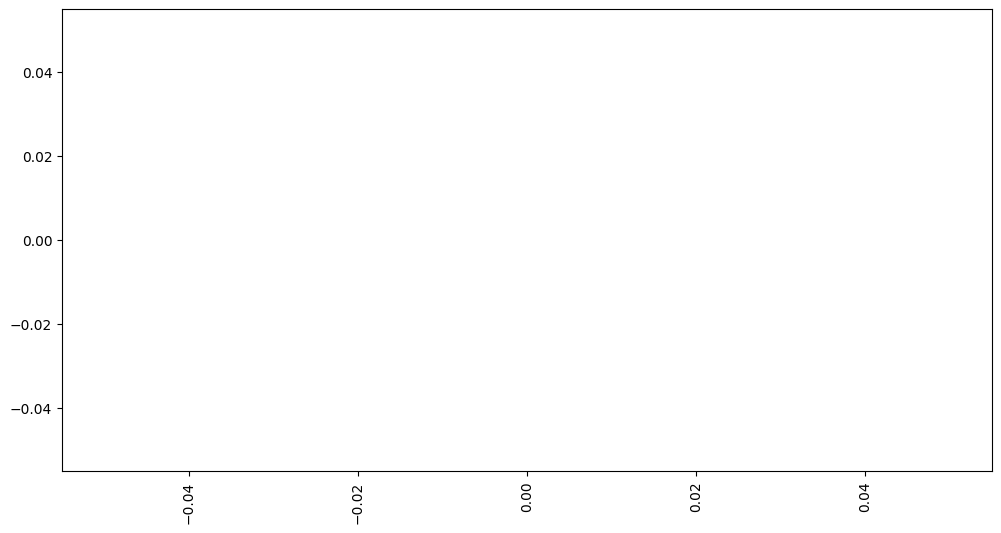

In [106]:
# 12. Analysis by Wards and Streets in Bristol
if not crimes_df.empty:
    # Extract ward and street information if available
    crimes_df['ward'] = crimes_df['location'].apply(lambda x: x.get('ward', None) if isinstance(x, dict) else None)
    crimes_df['street_name'] = crimes_df['location'].apply(lambda x: x['street']['name'] if isinstance(x, dict) and x.get('street') and x['street'].get('name') else None)
    # Analysis: Crime count by ward
    ward_counts = crimes_df['ward'].value_counts(dropna=True)
    print('Top 10 Wards by Crime Count:')
    print(ward_counts.head(10))
    # Analysis: Crime count by street
    street_counts = crimes_df['street_name'].value_counts(dropna=True)
    print('\nTop 10 Streets by Crime Count:')
    print(street_counts.head(10))
    # Visualization: Top 10 wards
    plt.figure(figsize=(12, 6))
    ward_counts.head(10).plot(kind='bar', color='skyblue')
    plt.title('Top 10 Wards by Crime Count')
    plt.xlabel('Ward')
    plt.ylabel('Number of Crimes')
    plt.show()
    # Visualization: Top 10 streets
    plt.figure(figsize=(12, 6))
    street_counts.head(10).plot(kind='bar', color='salmon')
    plt.title('Top 10 Streets by Crime Count')
    plt.xlabel('Street')
    plt.ylabel('Number of Crimes')
    plt.show()
else:
    print('crimes_df is empty, cannot analyze by ward or street.')

In [ ]:
# Streamlit Dashboard for SafeBristol Visualization
# To run: Save this as app.py and run `streamlit run app.py` in your terminal
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

st.set_page_config(page_title="SafeBristol Crime Dashboard", layout="wide")
st.title("SafeBristol: Crime Prediction & Safety Dashboard")

# Load data (assume crimes_df is available or load from a CSV/parquet if needed)
# For demonstration, you can save crimes_df to a CSV and load here:
# crimes_df = pd.read_csv('crimes_api_all_df.csv')

# Sidebar filters
st.sidebar.header("Filters")
ward_filter = st.sidebar.text_input("Ward (leave blank for all)")
street_filter = st.sidebar.text_input("Street (leave blank for all)")
category_filter = st.sidebar.text_input("Crime Category (leave blank for all)")

# Filter data
df = crimes_df.copy() if 'crimes_df' in globals() else pd.DataFrame()
if not df.empty:
    if ward_filter:
        df = df[df['ward'].str.contains(ward_filter, na=False, case=False)]
    if street_filter:
        df = df[df['street_name'].str.contains(street_filter, na=False, case=False)]
    if category_filter:
        df = df[df['category'].str.contains(category_filter, na=False, case=False)]

    st.subheader("Crime Hotspots (Heatmap)")
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.kdeplot(x=df['lng'], y=df['lat'], cmap='Reds', fill=True, thresh=0.05, ax=ax)
    ax.set_title('Bristol Crime Hotspots')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    st.pyplot(fig)

    st.subheader("Top 10 Wards by Crime Count")
    ward_counts = df['ward'].value_counts().head(10)
    st.bar_chart(ward_counts)

    st.subheader("Top 10 Streets by Crime Count")
    street_counts = df['street_name'].value_counts().head(10)
    st.bar_chart(street_counts)

    st.subheader("Crime Category Distribution")
    category_counts = df['category'].value_counts().head(10)
    st.bar_chart(category_counts)

    st.subheader("Raw Data Preview")
    st.dataframe(df.head(100))
else:
    st.warning("No crime data available. Please ensure crimes_df is loaded.")

ModuleNotFoundError: No module named 'streamlit'